---

# 1 Introduction

Using three datasets with data on user visits, orders and marketing costs, this report takes stock of the health of Yandex.Afisha product and marketing activities. The principal goal is to identify weaknesses of currently employed instruments in order to optimise future allocation of expenses. To get a full view of the enterprise, I investigate several key metrics revolving around (a) customers' engagement with the product, (b) sales of the product and (c) marketing expenses. The main finding is that several unprofitable campaigns undermine the short-term profitability of an otherwise well received product. The report closes with a set of recommendations that may help the management to address these shortcomings. 

### Fast Navigation 

* **[Data Preprocessing](#preprocessing)**
* **[Reports and Metrics](#reports)**
   * [Product](#product)
   * [Sales](#sales)
   * [Marketing](#marketing)

* **[Conclusion and Recommendations](#conclusion)**

<a id="preprocessing"></a>

# 2 Data Preprocessing

Let's have a first look at the data to see if additional cleaning is necessary.

In [2]:
! pip install squarify

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import math as mt 
import squarify 
import matplotlib
import matplotlib.ticker as mtick
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

try: 
    visits= pd.read_csv("visits_log_us.csv")
    orders= pd.read_csv("orders_log_us.csv")
    costs= pd.read_csv("costs_us.csv")
except:
    visits= pd.read_csv("/datasets/visits_log_us.csv")
    orders= pd.read_csv("/datasets/orders_log_us.csv")
    costs= pd.read_csv("/datasets/costs_us.csv")

datasets= [visits, orders, costs]

for i in datasets: 
    display(i.info())
    display(i.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


I will change the columns in orders and visits to lower case and convert the date columns to datetime since we'll need these a lot in the analysis. I'll also check both dataframes for duplicates.

In [4]:
visits.columns= visits.columns.str.lower()
orders.columns= orders.columns.str.lower()
visits= visits.rename({'source id': 'source_id'}, axis= 1)

visits['start ts']= pd.to_datetime(visits['start ts'], format= "%Y/%m/%d %H:%M:%S")
visits['end ts'] = pd.to_datetime(visits['end ts'], format= "%Y/%m/%d %H:%M:%S")

orders['buy ts']= pd.to_datetime(orders['buy ts'], format= "%Y/%m/%d %H:%M:%S")

print('Duplicates in the orders dataframe:', len(orders[orders.duplicated()]))
print('Duplicates in the visits dataframe:', len(visits[visits.duplicated()]))

Duplicates in the orders dataframe: 0
Duplicates in the visits dataframe: 0


<a id="reports"></a>
# 3 Reports and Metrics 

In the following section, I will calculate several metrics related to the activities of the business. The analysis is divided into three thematic subfields: Product, Sales and Marketing. 
<a id="product"></a>
### Product

In the product section, I will map out how and how often users interact with the products. Key metrics to be investigated are: 
- DAU, WAU, MAU (Use Frequency) 
- Sticky Factor (Customer Loyalty) 
- Number of sessions per day 
- ASL (Average Session Length) 
- User retention rate

#### Daily Active Users 

In [5]:
visits['session_year']= visits['start ts'].dt.year
#visits['session_month']= visits['start ts'].dt.month
#visits['session_week']= visits['start ts'].dt.week 
visits['session_date']= pd.to_datetime(visits['start ts'].dt.date)
visits['session_year_month']= visits['start ts'].dt.to_period('M')
visits['session_year_week']= visits['start ts'].dt.to_period('W').apply(lambda r: r.start_time)


dau_total= visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total= visits.groupby('session_year_week').agg({'uid': 'nunique'}).mean()
mau_total= visits.groupby('session_year_month').agg({'uid': 'nunique'}).mean()


print("Daily active users:", int(dau_total))
print("Weekly active users:", int(wau_total))
print("Monthly active users:", int(mau_total))

Daily active users: 907
Weekly active users: 5716
Monthly active users: 23228


In [6]:
# I do that to have the columns in the dataset 
visits['dau']= visits.groupby('session_date')['uid'].transform('nunique')
visits['wau']= visits.groupby('session_year_week')['uid'].transform('nunique')
visits['mau']= visits.groupby('session_year_month')['uid'].transform('nunique')
visits['sticky_factor']= visits['dau']/visits['mau']


In [7]:
visits['quarter']=   pd.PeriodIndex(visits.session_date, freq= 'Q')

In [8]:
%%time
#visits['sticky_factor']= visits['dau']/visits['mau']
#visits['quarter']= visits['session_date'].apply(quarters)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs


In [9]:
no1= visits.groupby('session_date')['uid'].nunique().reset_index()
no1['quarters']= pd.PeriodIndex(no1['session_date'], freq= 'Q')
no1= no1.groupby('quarters').agg({'uid':'mean'})
no2= visits.groupby('session_year_week')['uid'].nunique().reset_index()
no2['quarters']= pd.PeriodIndex(no2['session_year_week'], freq= 'Q')
no2= no2.groupby('quarters').agg({'uid':'mean'})
no3= visits.groupby('session_year_month')['uid'].nunique().reset_index()
no3['session_year_month']= no3['session_year_month'].astype('str')
no3['session_year_month'] = pd.to_datetime(no3['session_year_month'])
no3['quarters']= pd.PeriodIndex(no3['session_year_month'], freq= 'Q')
no3= no3.groupby('quarters').agg({'uid':'mean'})

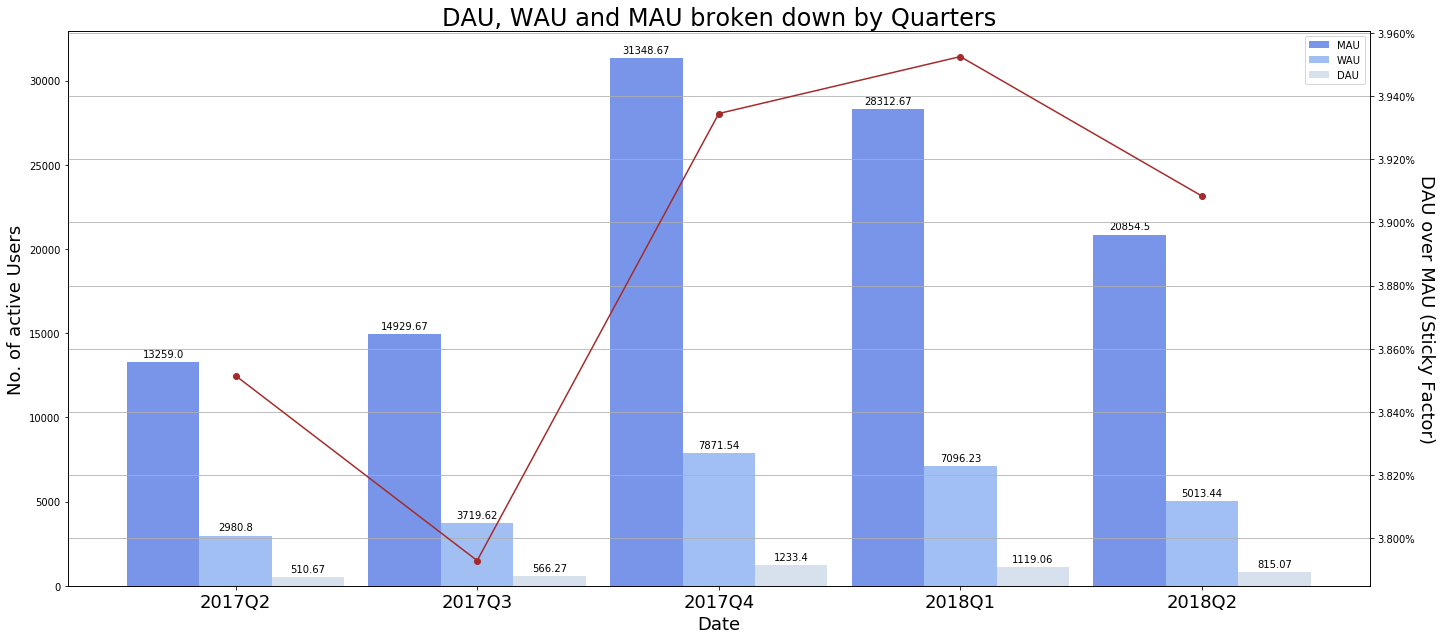

In [10]:
labels= list(no3.index.values)

x= np.arange(len(labels))
width= 0.3

fig, ax= plt.subplots(figsize= (20,9))
mau= ax.bar(x-width, round(no3['uid'],2), width, label= 'MAU', color= 'royalblue', alpha= 0.7)
wau= ax.bar(x, round(no2['uid'],2), width, label= 'WAU', color= 'cornflowerblue', alpha= 0.6)
dau= ax.bar(x+ width, round(no1['uid'],2), width, label= 'DAU', color= 'lightsteelblue', alpha= 0.5)


ax.set_ylabel('No. of active Users', size= 18)
ax.set_title('DAU, WAU and MAU broken down by Quarters', size= 24)
ax.set_xticks(x)
ax.set_xticklabels(labels, size= 18)
plt.xlabel('Date', size= 18)
ax.legend()

ax2= ax.twinx()
ax2.plot(x, no1['uid']/no3['uid']*100, 'g-o', color= 'brown', alpha= 2)
ax2.set_ylabel('DAU over MAU (Sticky Factor)', size= 18).set_rotation(270)
ax2.yaxis.set_label_coords(1.05, 0.5)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(mau)
autolabel(wau)
autolabel(dau)
#ax.bar_label(dau, padding=3)
ax2.yaxis.grid()
fig.tight_layout()
plt.show()


Ever since the 100% increase in DAU, WAU and MAU from Q3-2017 to Q4-2017, the app has consistently lost active users.  Moreover, the sticky factor of less than 4% implies that the average customer uses the app roughly one day per month (30*0.04= 1.2). The interpretation of this value, however, ultimately depends on the service the app provides. If it's a less frequently needed service that would result in a lower ratio.

#### Number of Sessions per Day 

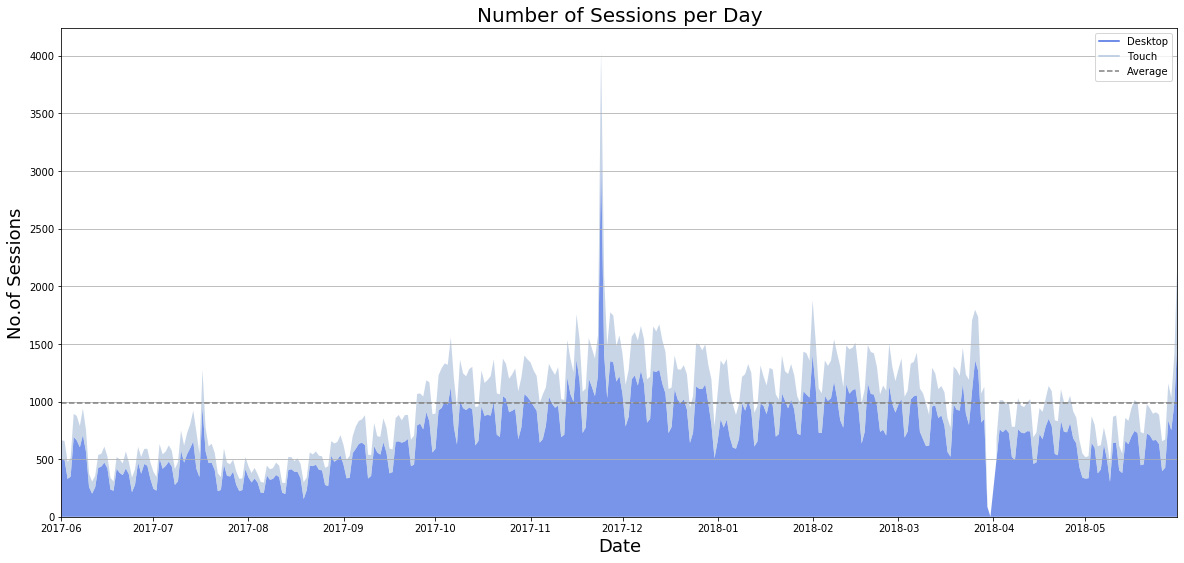

| desktop |
----------------
| Mean | 721.34
| Median: | 711.0
| Standard Deviation: | 322.33

| touch |
----------------
| Mean | 266.76
| Median: | 278.0
| Standard Deviation: | 110.86

| total |
----------------
| Mean | 990.08
| Median: | 1010.0
| Standard Deviation: | 416.35



In [11]:
# That's just done to have the values in the dataset 
visits['total_daily_session']= visits.groupby('session_date')['uid'].transform('count')

#plt.plot(visits['session_date'], visits['total_daily_session'])

daily_session_pivot= visits.pivot_table(index= 'session_date',\
                                        values= 'uid',\
                                       columns= 'device',\
                                       aggfunc= 'count')

daily_session_pivot['total']= daily_session_pivot['desktop']+daily_session_pivot['touch']

fig, ax= plt.subplots(figsize= (20,9))
x= np.arange(0,len(daily_session_pivot),1)
labels= list(daily_session_pivot.index.values)
ax.set_title('Number of Sessions per Day', size= 20, color= 'black')

ax.plot([], [], color ='royalblue',
         label ='Desktop')
ax.plot([], [], color ='lightsteelblue',
         label ='Touch')
ax.stackplot(daily_session_pivot.index.values, daily_session_pivot['desktop'],\
              daily_session_pivot['touch'], colors= ['royalblue','lightsteelblue'], alpha= 0.7)
plt.xlabel('Date', size= 18)
plt.ylabel('No.of Sessions',size= 18)
ax.yaxis.grid()
plt.xlim(min(daily_session_pivot.index.values),max(daily_session_pivot.index.values))

plt.plot(daily_session_pivot.index.values, \
         list(np.repeat(daily_session_pivot['total'].mean(), \
                        len(daily_session_pivot))),'--', color= 'grey',label= 'Average')

plt.legend()
plt.show()
for name, data in daily_session_pivot.iteritems():
    print('|',name,'|')
    print('----------------')
    print('|', 'Mean','|', np.round(data.mean(),2))
    print('|', 'Median:','|', np.round(data.median(),2))
    print('|', 'Standard Deviation:','|', np.round(data.std(),2))
    print('')

The average number of sessions is 990 sessions per day with a standard deviation of 416.35.

The product is used almost three times more often on desktop than on mobile devices which indicates that it is less convenient to use it on the phone. 

#### Average Session Length 

When looking for average session length it is good practice to first check the distribution of the variable to find the appropriate measure. 

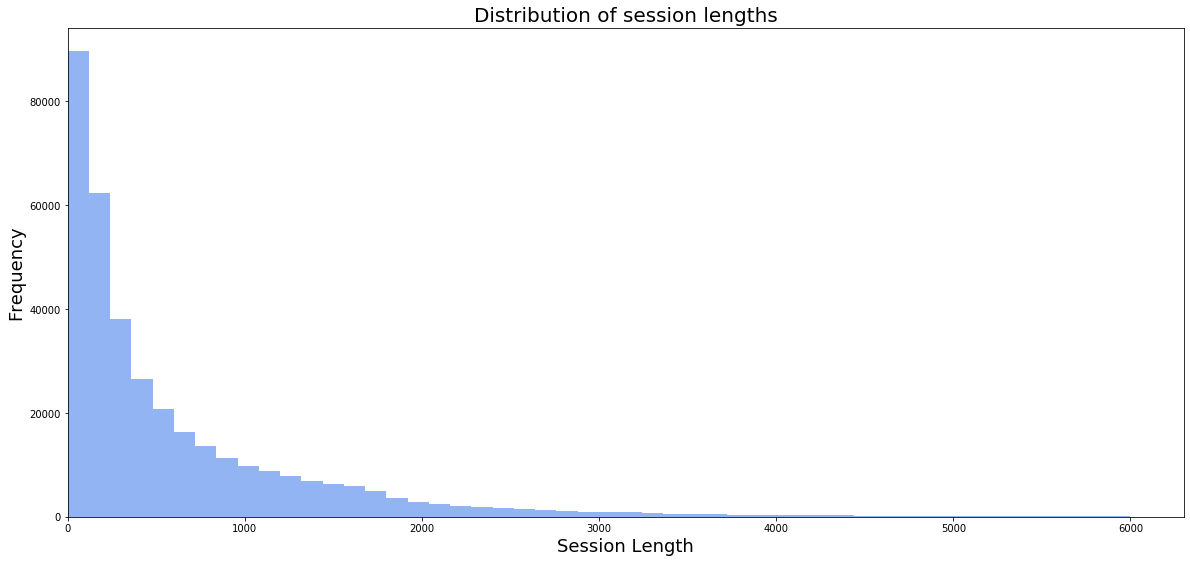

In [12]:
visits['session_length']= ((visits['end ts']-visits['start ts']).dt.seconds)
plt.figure(figsize= (20,9))
plt.hist(visits['session_length'], bins= 50, range=(0,6000), color= 'cornflowerblue', alpha= 0.7)
plt.title('Distribution of session lengths', size= 20)
plt.xlabel('Session Length', size= 18)
plt.ylabel('Frequency', size= 18)
plt.xlim(min(visits['session_length']))
plt.show()

As the distribution is strongly skewed to the right, mean will not help us much. Therefore, I'll look at mode and median. 

In [13]:
print("Mode session length:", int(visits['session_length'].mode()), "second(s)")
print("Median session length:", int(visits['session_length'].median()), "second(s)")

Mode session length: 60 second(s)
Median session length: 300 second(s)


#### How often do users come back? 

In the following, I will calculate monthly retention rates for different cohorts. It does not make much sense to regard retention rates on a weekly basis as the sticky factor showed us that users rarely use the app more often than once a month. As such, the lifetime of a customer should be regarded in terms of months rather than weeks. The function created below would still allow to make the analysis for weeks but I decided to skip this part. I will analyse retention for both visits and orders. 

In [14]:
%%time

def week_diff(end,start):
    d1= end - pd.to_timedelta(end.dt.dayofweek, unit= 'd')
    d2= start - pd.to_timedelta(start.dt.dayofweek, unit= 'd') 
    d3= (d1-d2)/np.timedelta64(1,'W')
    return(d3.astype('int'))

def month_diff(end, start):
    d1= (end.dt.year-start.dt.year)*12
    d2= end.dt.month - start.dt.month
    return(d2+d1)

# create the new columns 
   
orders['first_purchase']= orders.groupby('uid')['buy ts'].transform('min')
orders['year_month_first_purchase']=  orders['first_purchase'].dt.to_period('M')
orders['difference_to_first_purchase_month']=  month_diff(orders['buy ts'], orders['first_purchase'])
#orders['year_week_first_purchase']= orders['first_purchase'].dt.to_period('W').apply(lambda r: r.start_time)
orders['year_week_first_purchase']= orders['first_purchase'].dt.to_period('W').dt.start_time
orders['difference_to_first_purchase_week']= week_diff(orders['buy ts'], orders['first_purchase'])

                                                                                           
visits['first_visit']= visits.groupby('uid')['start ts'].transform('min')
visits['year_month_first_visit']=  visits['first_visit'].dt.to_period('M')
visits['difference_to_first_visit_month']= month_diff(visits['start ts'], visits['first_visit'])
#visits['year_week_first_visit']= visits['first_visit'].dt.to_period('W').apply(lambda x: x.start_time)
visits['year_week_first_visit']= visits['first_visit'].dt.to_period('W').dt.start_time
visits['difference_to_first_visit_week']= week_diff(visits['start ts'], visits['first_visit'])
visits['source_id']= visits['source_id'].astype(str)


CPU times: user 1min, sys: 239 ms, total: 1min
Wall time: 1min 1s


In [15]:
# function to create the heatmaps 
def retention_rates(df, time, purpose, group, name): 
    if group== 'Cohort':
        ind= 'year_{tim}_first_{purp}'.format(tim= time,purp= purpose)    
    else: 
        ind= "source_id"
    retention= df.pivot_table(index= ind ,\
                                  columns='difference_to_first_{purp}_{tim}'.format(purp= purpose, tim= time), \
                                  values= 'uid', \
                                  aggfunc= 'nunique')
    for item in list(retention[retention.columns.difference([0])]):
        for row in np.arange(0, len(retention)):
            retention[item][row]= (retention[item][row]/retention[0][row])
    retention[0]= 1
    sns.set(style='white')
    plt.figure(figsize=(20, 9))
    plt.title('Cohorts: User Retention in terms of {nam}'.format(nam= name), size= 20)
    sns.heatmap(
        retention, annot=True, fmt='.2%', linewidths=1, linecolor='gray', cmap= 'Blues'
    ) 
    plt.yticks(rotation=0) 
    if purpose== 'visit':
        plt.xlabel('Cohort Lifetime')
        plt.ylabel('Cohort (First Visit)')
    else: 
        plt.xlabel('Months since first Purchase')
        plt.ylabel('Cohort (First Purchase)')
 

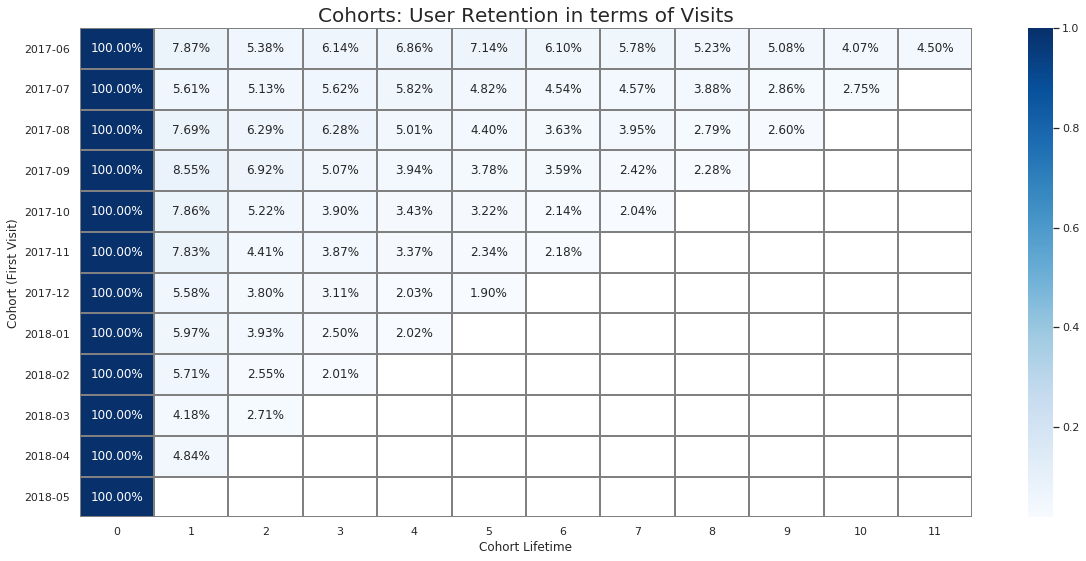

In [16]:
retention_rates(visits, 'month', 'visit', 'Cohort', 'Visits')

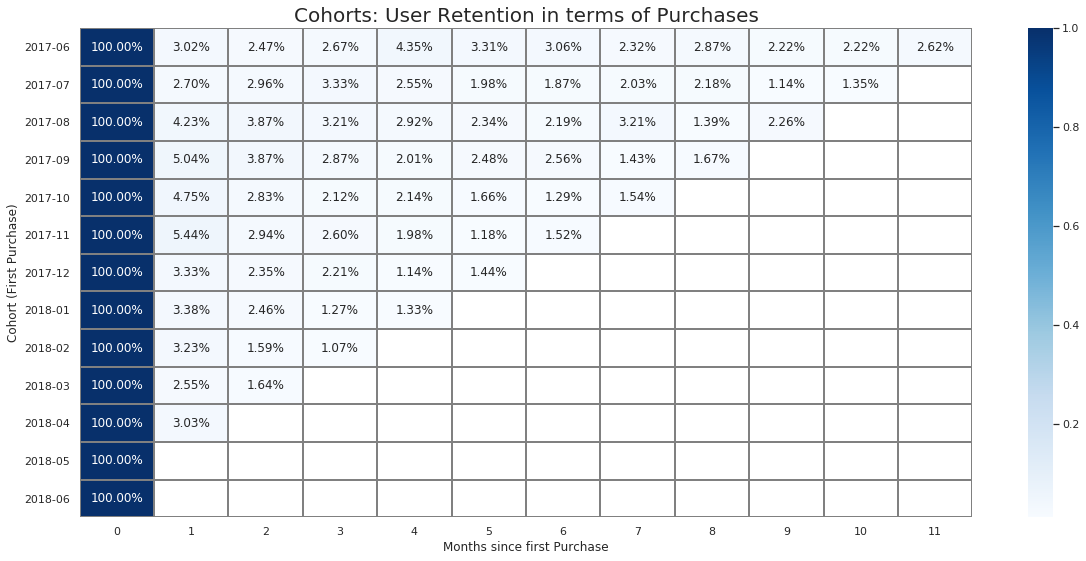

In [17]:
retention_rates(orders, 'month', 'purchase', 'Cohort', 'Purchases')

As the heatmaps show, retention rates are very low for most cohorts and more than 90% of visitors are lost after the first month. For orders, the effect is even more accentuated. It is remarkable that users of the first cohort seem to come back at a much higher rate. Perhaps, the company made a lasting first impression. 

### Conclusion 

Judging from DAU, WAU and MAU and the number of sessions, the product is losing popularity among customers. Moreover, the generally low first-month retention rates have been on steady decline for every new cohort after September 2017. Based on these metrics measures should be taken to improve the popularity of the product. 

<a id="sales"></a>
## Sales 


This section is all about the sales patterns of the company and asks when customers start buying a product, how much the company sells in total, how much customers buy on average and how much money an average customer generates  throughout his/her entire relationship with the company. To answer these questions, the following metrics will be considered: 

- Conversion time
- Orders per month 
- Average purchase size 
- Customer Lifetime Value (CLTV)

All these metrics are further broken down by source, cohort or cohort lifetime. 

#### When do people start buying?

In [18]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 21 columns):
device                             359400 non-null object
end ts                             359400 non-null datetime64[ns]
source_id                          359400 non-null object
start ts                           359400 non-null datetime64[ns]
uid                                359400 non-null uint64
session_year                       359400 non-null int64
session_date                       359400 non-null datetime64[ns]
session_year_month                 359400 non-null period[M]
session_year_week                  359400 non-null datetime64[ns]
dau                                359400 non-null uint64
wau                                359400 non-null uint64
mau                                359400 non-null uint64
sticky_factor                      359400 non-null float64
quarter                            359400 non-null period[Q-DEC]
total_daily_session                

In [19]:
#visits.session_date= pd.to_datetime(visits.session_date)
#orders['session_date']
visits['session_date'][55028]


Timestamp('2018-01-15 00:00:00')

In [20]:

#log.loc[log['difference_to_first_visit_month'].isna(), 'difference_to_first_visit_month']= log.loc[log['difference_to_first_visit_month'].isna()]\
#.#apply(lambda x:month_diff(x['buy ts'], x['first_visit']), axis= 1)

In [21]:
orders['session_date']= orders['buy ts'].dt.date
orders['session_date']= pd.to_datetime(orders.session_date)

log= pd.merge(visits, orders, how= 'right', right_on= ['session_date', 'uid'],left_on= ['session_date', 'uid']).drop_duplicates(subset= ['uid','buy ts'])
log.loc[log['first_visit'].isna(), 'first_visit']= log.loc[log['first_visit'].isna(), 'first_purchase']
log.loc[log['year_month_first_visit'].isna(), 'year_month_first_visit']= log.loc[log['year_month_first_visit'].isna(), 'year_month_first_purchase']
log.loc[log['year_week_first_visit'].isna(), 'year_week_first_visit']= log.loc[log['year_week_first_visit'].isna(), 'year_week_first_purchase']
log.loc[log['session_year_month'].isna(), 'session_year_month']= pd.to_datetime(log.loc[log['session_year_month'].isna()]['session_date'], format= '%Y-%m-%d').dt.to_period('M')
log.loc[log['difference_to_first_visit_month'].isna(), 'difference_to_first_visit_month']= month_diff(log.loc[log['difference_to_first_visit_month'].isna()]['buy ts'],\
log.loc[log['difference_to_first_visit_month'].isna()]['first_visit'])

#.apply(lambda x:month_diff(x['buy ts'], x['first_visit']), axis= 1)
log['conversion_time']= ((log['year_week_first_purchase']-log['year_week_first_visit']).dt.days).fillna(0)
log_relevant= log.loc[log.groupby('uid')['buy ts'].idxmin()].drop_duplicates()

In [22]:
def conv(x):
    if x == 0:
        return ('Conv-0d')
    if 0 < x < 8:
        return ('Conv-7d')
    if 7 < x < 15:
        return('Conv-14d')
    if 14 < x < 22:
        return ('Conv-21d')
    if 21 < x < 29:
        return('Conv-28d')
    if 28 < x < 36:
        return('Conv-35d')
    if 35 < x:
        return ('Conv-late')


log_relevant['conversion_group']= log_relevant['conversion_time'].map(conv)

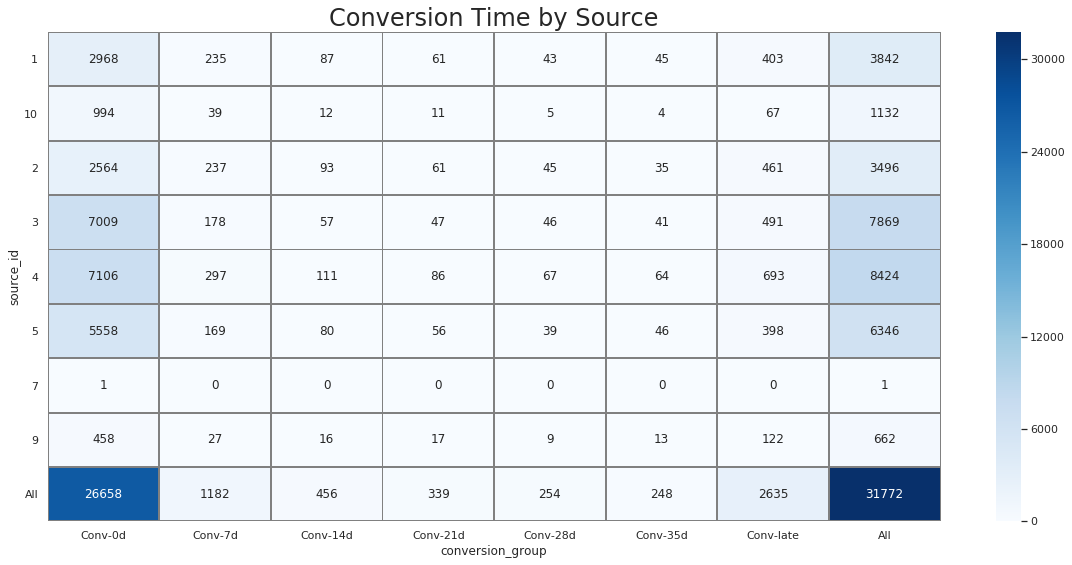

In [23]:
conv_table= pd.crosstab(log_relevant['source_id'], log_relevant['conversion_group'], margins= True)
cols= ['Conv-0d',
 'Conv-7d',
 'Conv-14d',
 'Conv-21d',
 'Conv-28d',
 'Conv-35d',
 'Conv-late',
 'All']
conv_table= conv_table[cols]
plt.figure(figsize= (20,9))
plt.title('Conversion Time by Source', size= 24)
sns.heatmap(conv_table, annot=True, fmt='g',linewidths=1 , linecolor='gray', cmap= 'Blues')
plt.yticks(rotation= 0)
plt.show()

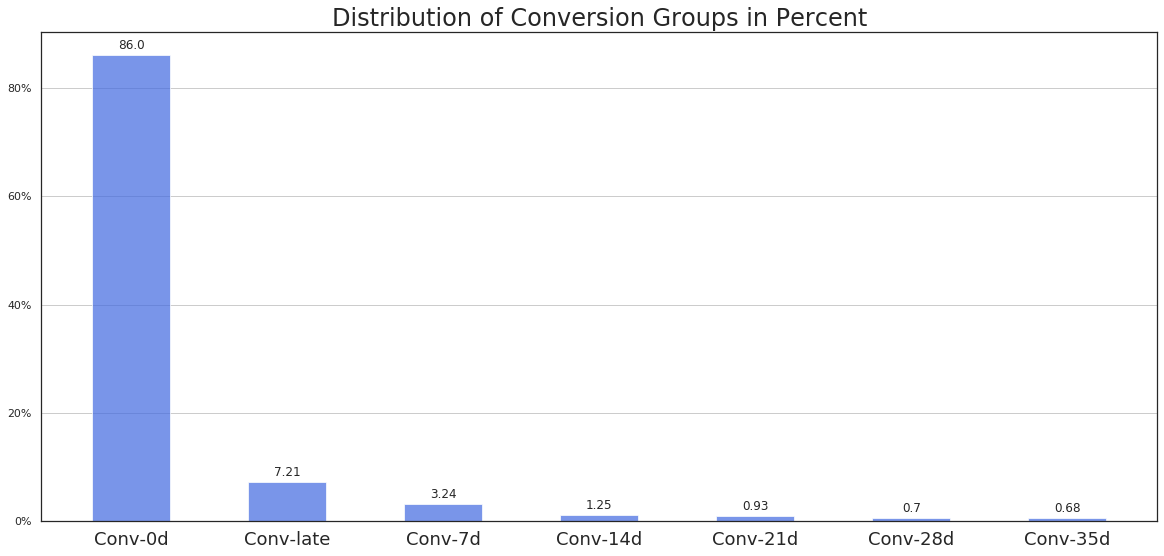

In [25]:
#log_relevant.groupby
conv_gr= pd.DataFrame(log_relevant.groupby('conversion_group')['uid'].count()/sum(log_relevant.groupby('conversion_group')['uid'].count())*100)\
                      .sort_values('uid', ascending= False)
                      
conv_gr['uid']= conv_gr['uid'].round(2)
labels= list(conv_gr.index.values)
x= np.arange(len(labels))

fig, ax= plt.subplots(figsize= (20,9))
width= 0.5
#x= x.tic
bar_conv= ax.bar(x, conv_gr['uid'], width, label= 'MAU',alpha= 0.7, color= 'royalblue')


ax.set_title('Distribution of Conversion Groups in Percent', size= 24)
ax.set_xticks(x)
ax.set_xticklabels(labels, size= 18)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.grid()
autolabel(bar_conv)
plt.show()

The vast majority of purchases (86%) are made within a week after the website was first visited

In [26]:
conversion_rate= (len(log_relevant)/visits.merge(orders, on= 'uid', how= 'outer')['uid'].nunique())
print('The conversion rate is {:.2%}'.format(conversion_rate))

The conversion rate is 16.01%


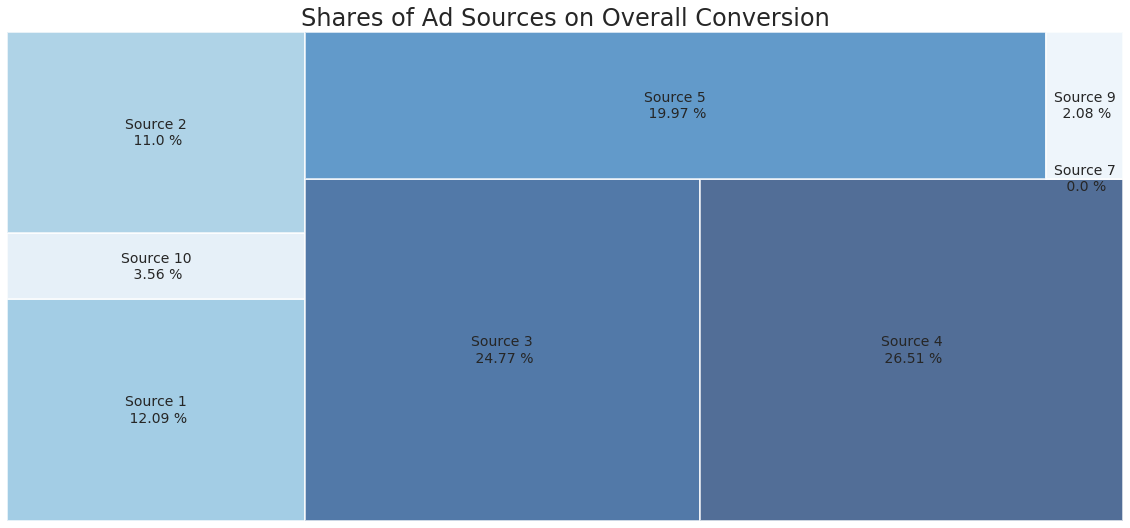

In [27]:
#log_relevant.groupby('source_id').agg({'conversion_group'})
source_conv= pd.DataFrame(log_relevant.groupby('source_id')['uid'].count())
source_conv['percent']= (log_relevant.groupby('source_id')['uid'].count()/sum(log_relevant.groupby('source_id')['uid'].count())*100).round(3)

cmap = matplotlib.cm.Blues
mini=min(source_conv['percent'])
maxi=max(source_conv['percent'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in source_conv['percent']]
    
source_conv= source_conv.reset_index().sort_values('source_id')
source_conv['source_id']= source_conv['source_id'].astype('int')
labels= ['Source {source}\n {pct} %'.format(source= int(x[0]), pct= np.round(x[2],2)) for x in source_conv.values]

plt.figure(figsize= (20,9))
plt.rc('font', size= 14)
squarify.plot(sizes= source_conv['percent'],linewidth= 2, label= labels,color= colors, alpha= 0.7)
plt.title('Shares of Ad Sources on Overall Conversion', size= 24)
plt.axis('off')
plt.show()

In [28]:
one= visits.groupby('source_id')['uid'].nunique().reset_index()
one['source_id']= one['source_id'].astype('int')

tog= source_conv.merge(one, how= 'left', on= 'source_id')
tog['conversion_rate']= tog['uid_x']/tog['uid_y']
tog2= tog.groupby('source_id').agg({'conversion_rate':'mean'}).sort_values('conversion_rate', ascending= False) #.query('conversion_rate != 36')

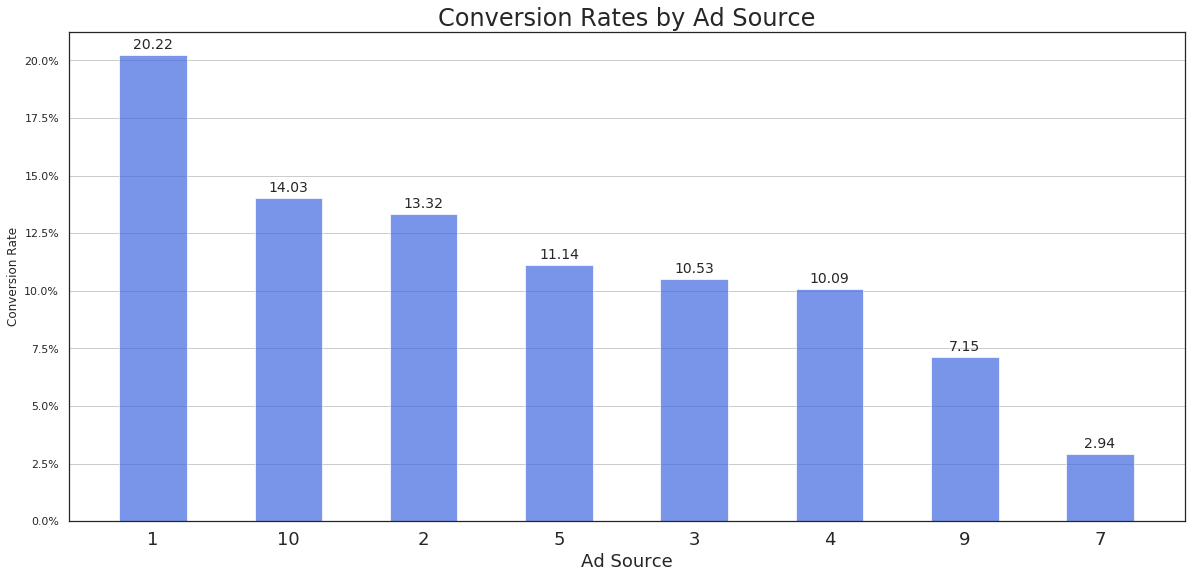

In [29]:
labels= list(tog2.index.values)
x= np.arange(len(labels))

fig, ax= plt.subplots(figsize= (20,9))
width= 0.5
#x= x.tic
bar_conv2= ax.bar(x,np.round(tog2['conversion_rate']*100,2), width, label= 'Conversion Rate',alpha= 0.7, color= 'royalblue')


ax.set_title('Conversion Rates by Ad Source', size= 24)
ax.set_xticks(x)
ax.set_xticklabels(labels, size= 18)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('Ad Source', size= 18)
plt.ylabel('Conversion Rate')
ax.yaxis.grid()
autolabel(bar_conv2)
plt.show()

A conversion rate of 16.01 % is excellent and places the company in the top league according to this metric. 

More than 70% of conversions come from source 3, 4 and 5. However, when adjusted for frequency of visits, the highest conversion rates are from sources 1, 10 and 2, followed by 5 and 3. Source 7 and 9 are not very successful, so it might pay off to focus on the strong sources and phase out the weaker ones. (Note: The overall conversion rate of 16.01% also considers 'no-cost'-conversions from people who came from no discernible source)

#### How many orders do they make during a given period of time?

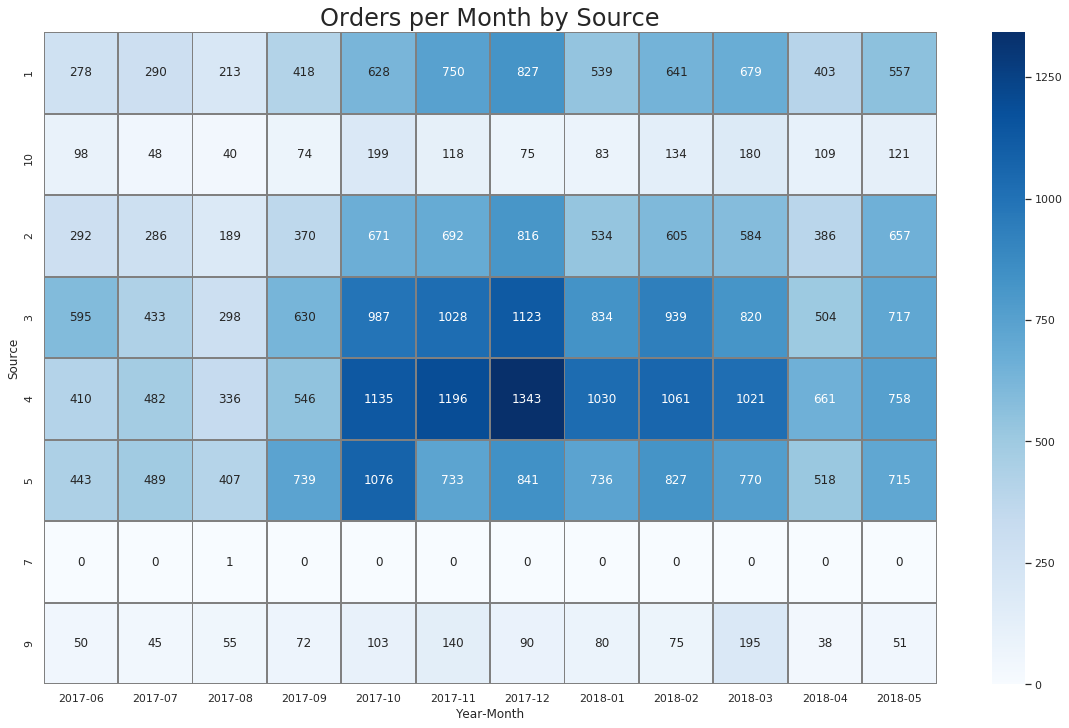

In [31]:
plt.figure(figsize= (20,12))
table2= log.pivot_table(index= 'source_id', columns= 'session_year_month', values= 'uid', aggfunc= 'count').fillna(0)

sns.set(style='white')
plt.title('Orders per Month by Source',size= 24)
sns.heatmap(table2, annot= True, fmt= 'g',linewidths=1, linecolor='gray', cmap= 'Blues')
plt.xlabel('Year-Month')
plt.ylabel('Source')
plt.show()

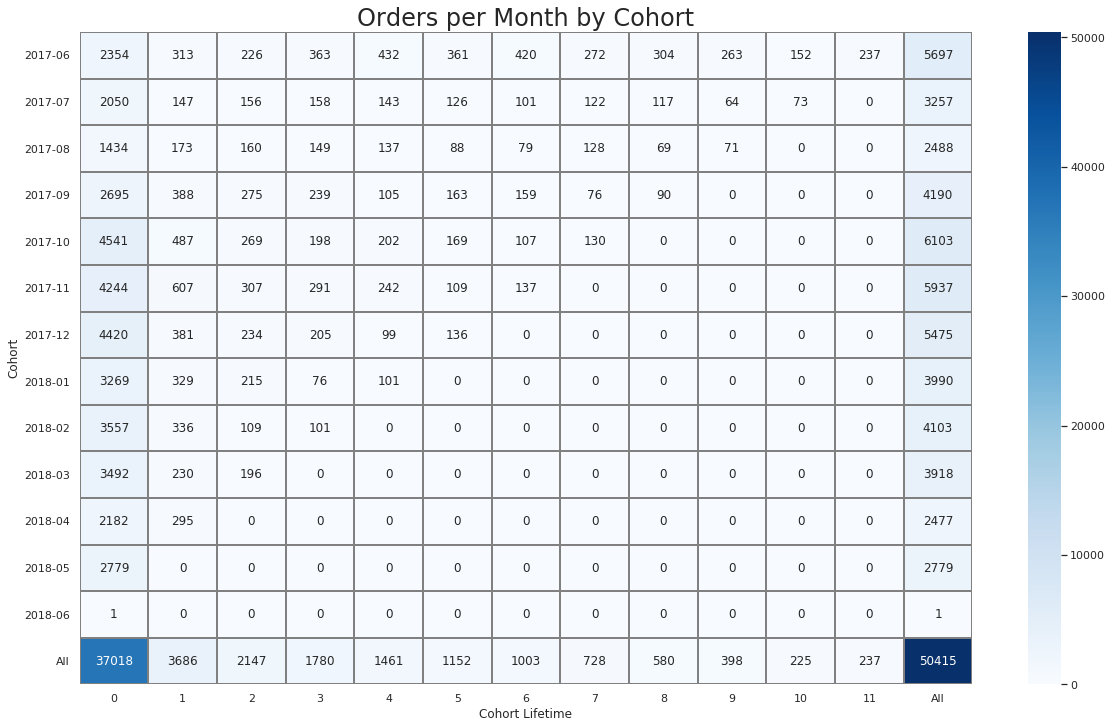

In [32]:
log['difference_to_first_visit_month']= log['difference_to_first_visit_month'].astype('int')
table3= pd.crosstab(log['year_month_first_visit'], log['difference_to_first_visit_month'], margins= True)
plt.figure(figsize= (20,12))
sns.set(style='white')
plt.title('Orders per Month by Cohort',size= 24)
sns.heatmap(table3, annot= True, fmt= 'g',linewidths=1, linecolor='gray', cmap= 'Blues')
plt.yticks(rotation= 0)
plt.xlabel('Cohort Lifetime')
plt.ylabel('Cohort')
plt.show()

The heatmaps show that purchases coming from source 3,4 and 5 peaked between October 2017 and March 2018 and the cohorts starting from these months have been the ones who bought the most.

#### What is the average purchase size? 

In [33]:
table5 = pd.DataFrame(log.groupby('session_year_month')['uid'].count())
table5= table5[:12]

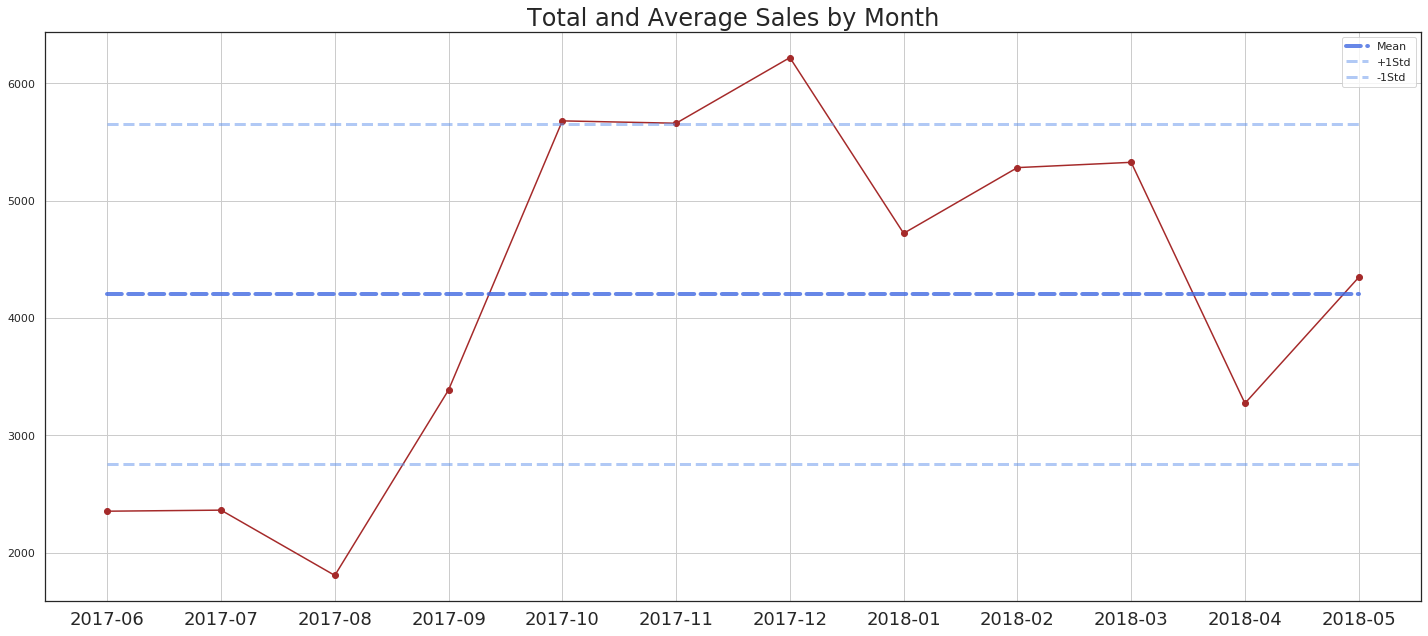

,uid
count,12.000000
mean,4201.166667
std,1511.972092
min,1807.000000
25%,3045.500000
50%,4533.500000
75%,5409.250000
max,6218.000000


In [34]:
## Add mean, median and standard deviation 
labels= list(table5.index.values)
x= np.arange(0,len(table5))

fig, ax= plt.subplots(figsize= (20,9))
std= np.std(table5['uid'])
ax.plot(x, table5['uid'],'g-o', color= 'brown')
ax.plot(x, np.repeat(table5['uid'].mean(), len(table5)),'--', color= 'royalblue', linewidth= 4, label= 'Mean', dash_capstyle='round', alpha= 0.8)
ax.plot(x, np.repeat(table5['uid'].mean() +std,len(table5)),'--',color= 'cornflowerblue', linewidth= 3, label= '+1Std', alpha= 0.5)
ax.plot(x, np.repeat(table5['uid'].mean() -std,len(table5)),'--',color= 'cornflowerblue', linewidth= 3, label= '-1Std', alpha= 0.5)
ax.set_xticks(x)
ax.set_xticklabels(labels, size= 18)
plt.title('Total and Average Sales by Month', Size= 24)
plt.legend()
ax.grid()
fig.tight_layout()
plt.show()
display(table5.describe())

In [35]:
table4= log.pivot_table(index= 'difference_to_first_visit_month', columns= 'session_year_month', values= 'uid', aggfunc= 'count')
table4['mean']= table4.mean(axis=1)
table4['median']= table4.median(axis=1)
table4['std']= table4.std(axis=1)

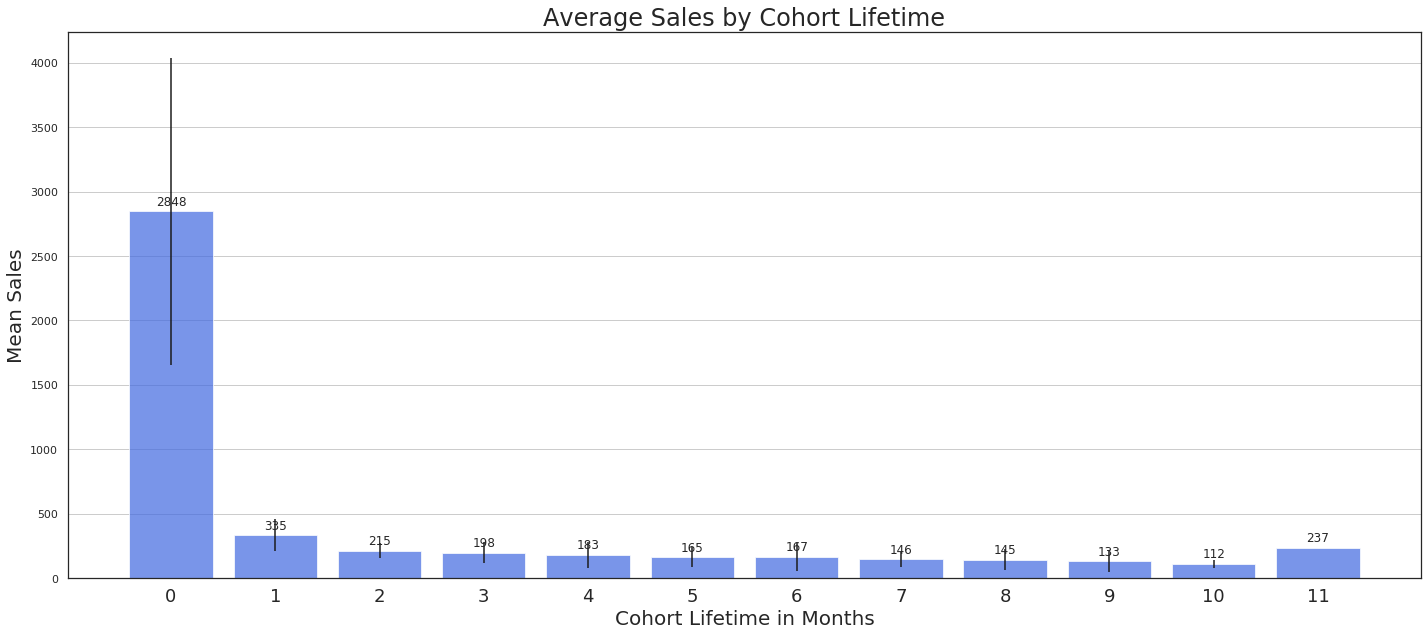

In [36]:
x= np.arange(len(table4))
labels= x

fig, ax= plt.subplots(figsize= (20,9))
width= 0.8
#x= x.tic
lifetime_plot= ax.bar(x, table4['mean'].round().astype(int),yerr= table4['std'],align= 'center', width= width,alpha= 0.7,color= 'royalblue')


ax.set_title('Average Sales by Cohort Lifetime', size= 24)
ax.set_xticks(x)
ax.set_xticklabels(labels, size= 18)
ax.yaxis.grid()
ax.set_xlabel('Cohort Lifetime in Months', size= 20)
ax.set_ylabel('Mean Sales', size= 20)
autolabel(lifetime_plot)
fig.tight_layout()
plt.show()

In terms of mean, the company sells 4201 units per month with a standard deviation of 1512. 
The vast majority of sales take place within one month after a customer visited the platform for the first time. 

#### How much money do they bring? (LTV)

In [58]:
log.pivot_table(index= 'year_month_first_visit', columns= 'difference_to_first_visit_month', values= 'revenue', aggfunc= 'sum').cumsum(axis=1)

difference_to_first_visit_month,0,1,2,3,4,5,6,7,8,9,10,11
year_month_first_visit,,,,,,,,,,,,
2017-06,9557.49,11635.99,12852.41,16107.44,19413.78,21901.36,24995.99,27004.94,28796.98,31519.96,33359.24,35064.14
2017-07,10460.97,11326.68,12311.80,13109.55,13776.35,14365.42,14765.14,15434.81,15989.53,16441.12,16777.36,NaN
2017-08,6676.65,7459.08,8304.51,9142.45,9907.02,10388.94,10801.59,11892.73,12707.64,13040.48,NaN,NaN
2017-09,13322.93,16855.24,18656.85,28964.69,30181.59,32011.23,33222.27,33815.07,34283.05,NaN,NaN,NaN
2017-10,19505.87,22599.68,23701.40,24645.76,25491.89,26183.17,26625.99,27158.49,NaN,NaN,NaN,NaN
2017-11,18182.19,20253.25,21351.74,22856.78,23828.67,24375.18,24951.22,NaN,NaN,NaN,NaN,NaN
2017-12,18459.71,19870.19,23971.23,28890.18,30277.85,31890.78,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,11856.31,13270.66,14498.94,14794.80,15238.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,12989.98,14501.06,15076.68,15854.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


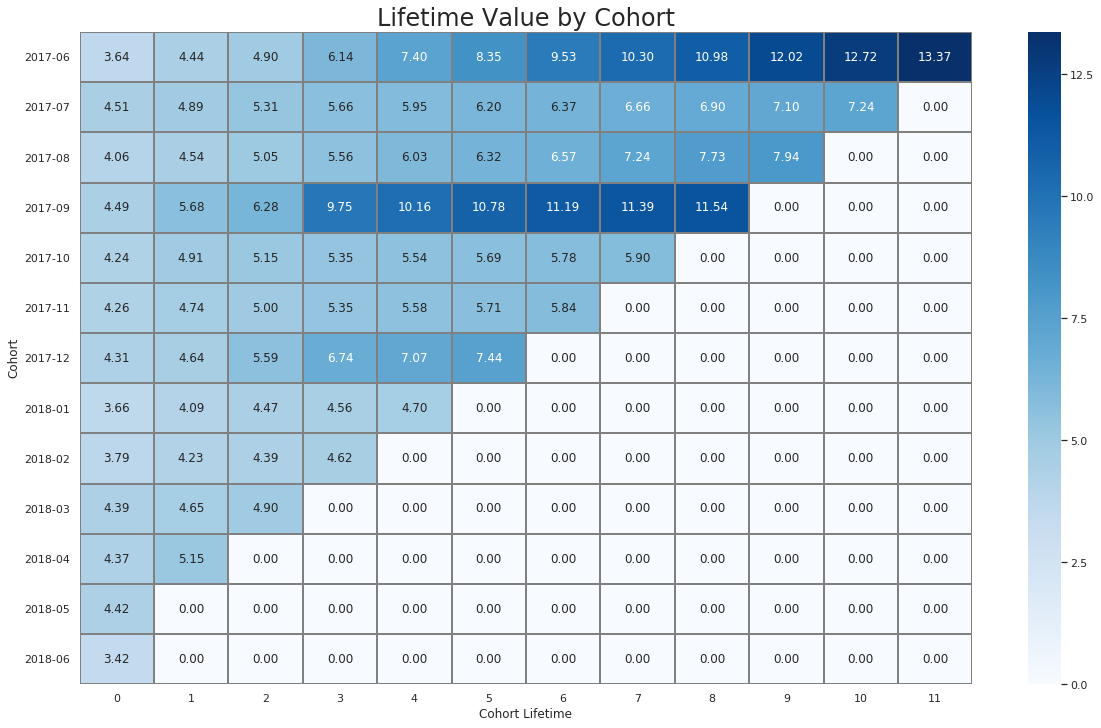

In [37]:
cohort_LTV= log.pivot_table(index= 'year_month_first_visit', columns= 'difference_to_first_visit_month', values= 'revenue', aggfunc= 'sum').cumsum(axis=1)
cohort_LTV['Cohort Size']= log.groupby('year_month_first_visit').agg({'uid':'nunique'})
for name,colData in cohort_LTV[cohort_LTV.columns.difference(['Cohort Size'])].iteritems():
    cohort_LTV[name]= np.round(colData/cohort_LTV['Cohort Size'],2)

cohort_LTV= cohort_LTV.fillna(0)
plt.figure(figsize= (20,12))

sns.set(style='white')
plt.title('Lifetime Value by Cohort',size= 24)
sns.heatmap(cohort_LTV[cohort_LTV.columns.difference(['Cohort Size'])], annot= True,fmt='.2f', linewidths=1, linecolor='gray', cmap= 'Blues')
plt.xlabel('Cohort Lifetime')
plt.ylabel('Cohort')
plt.yticks(rotation= 0)
plt.show()

Hi I checked your results but I actually believe that my table has the correct values. 

In [40]:
# Get number of users in every cohort.
cohort_size = orders.groupby('year_month_first_purchase').agg({'uid': 'nunique'})\
              .reset_index().rename(columns={'uid': 'n_buyers'})
# Caclulate revenue per cohorts.
ltv_report = orders.groupby(['year_month_first_purchase', 'difference_to_first_purchase_month'])\
             .agg({'revenue': 'sum'}).reset_index()
ltv_report = ltv_report.merge(cohort_size, on='year_month_first_purchase')
# Find LTV in every cohort.
ltv_report['ltv'] = ltv_report['revenue'] / ltv_report['n_buyers']
# Apply cumsum(). 
ltv_report.pivot_table(index='year_month_first_purchase', columns='difference_to_first_purchase_month', 
                       values='ltv', aggfunc='mean').cumsum(axis=1)

difference_to_first_purchase_month,0,1,2,3,4,5,6,7,8,9,10,11
year_month_first_purchase,,,,,,,,,,,,
2017-06,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
#####

In [42]:
log['session_date']= pd.to_datetime(log['session_date'], format= "%Y/%m/%d")
costs['dt']= pd.to_datetime(costs['dt'], format= "%Y/%m/%d")
log['source_id']= log['source_id'].fillna(0)
log['source_id']= log['source_id'].astype('int')
log= pd.merge(log, costs, how= 'left', left_on= ['session_date', 'source_id'], right_on= ['dt', 'source_id'])

In [43]:
LTV1= log.groupby('year_month_first_visit').agg({'revenue':'sum', 'uid':'nunique'})[:12]
LTV1['LTV']= (LTV1['revenue']/LTV1['uid']).round(2)
LTV1['months']= list(np.flip(np.arange(1,13,1)))
LTV1['LTV-year']= (LTV1['LTV']/LTV1['months']*12).round(2)
LTV1['difference']= LTV1['LTV-year']-LTV1['LTV']

for value in np.arange(0, len(LTV1), 1):
    if LTV1['months'][value] <= 5:
        LTV1['difference'][value]= 0

for value in np.arange(0, len(LTV1), 1):
    if LTV1['months'][value] <= 5:
        LTV1['LTV-year'][value]= 0

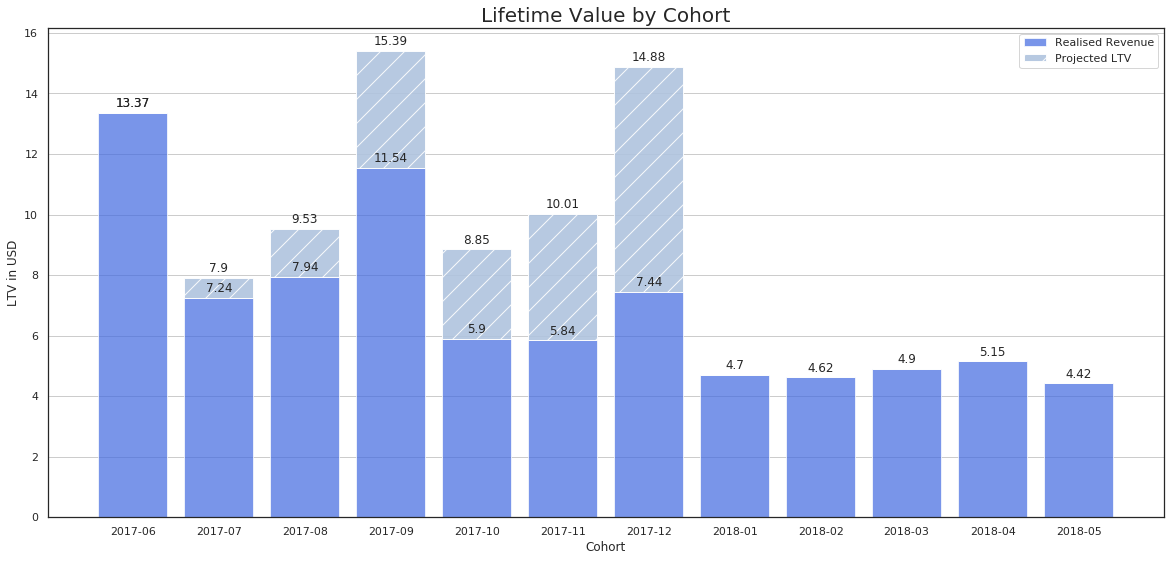

In [44]:
fig, ax= plt.subplots(figsize= (20,9))
x= np.arange(0,len(LTV1))
labels= list(LTV1.index.values)
chart= ax.bar(x,LTV1['LTV'],color= 'royalblue',align= 'center', alpha= 0.7, label= 'Realised Revenue')
chart2= ax.bar(x, np.round(LTV1['difference'], 2), color= 'lightsteelblue', align= 'center',hatch= "/", bottom= np.round(LTV1['LTV'],2), alpha= 0.9, label= 'Projected LTV') 
chart3= ax.bar(x, np.round(LTV1['LTV-year'], 2), color= 'lightsteelblue', align= 'center', alpha= 0.0)
#chart2= ax.bar(x, list(LTV1['difference']),align= 'center', color= 'cornflowerblue', alpha= 0.9, bottom= chart)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Lifetime Value by Cohort', size= 20)
ax.set_ylabel('LTV in USD')
ax.set_xlabel('Cohort')
ax.yaxis.grid()
autolabel(chart3[0:7])
autolabel(chart)
plt.legend()
plt.show()

Assuming a lifetime of one year, the barcharts show considerable difference in (projected) LTVs among different cohorts. For the July-17 to December-17 cohorts, LTV was extrapolated based on monthly averages of per capita revenue. For the 2018 cohorts there was not enough data for this simple approach to work. The barplot shows that (projected) LTVs range from 7.9 (2017-07) to 15.39 (2017-09). 

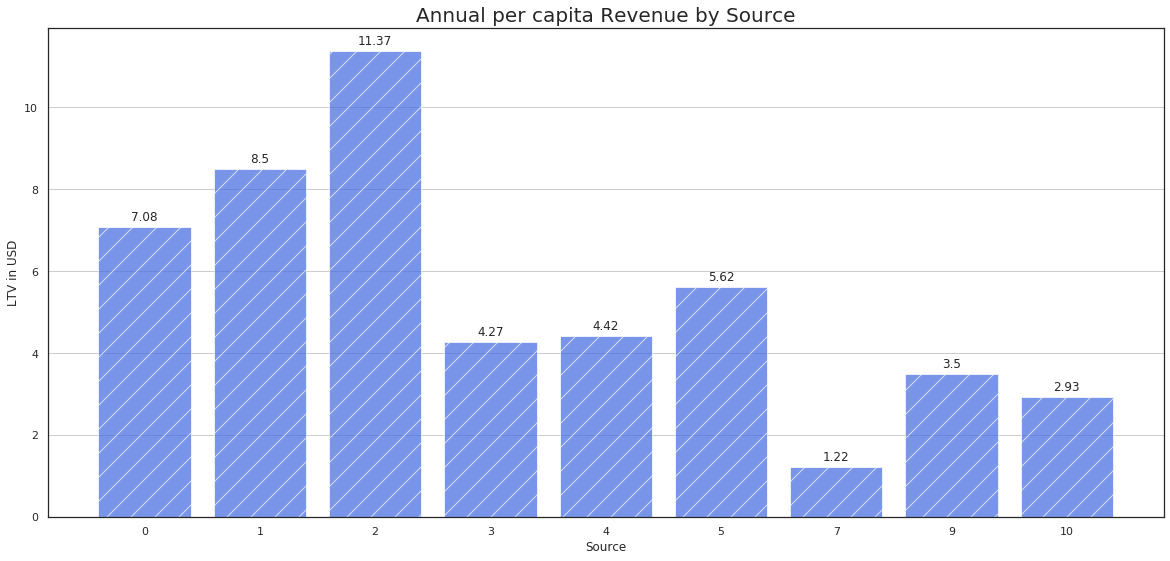

In [45]:
LTV2= log.groupby('source_id').agg({'revenue':'sum', 'uid':'nunique'})
LTV2['LTV']= (LTV2['revenue']/LTV2['uid']).round(2)
fig, ax= plt.subplots(figsize= (20,9))
x= np.arange(0,len(LTV2))
labels= list(LTV2.index.values)
chart= ax.bar(x,LTV2['LTV'],color= 'royalblue', alpha= 0.7, hatch= '/')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Annual per capita Revenue by Source', Size= 20)
ax.set_ylabel('LTV in USD')
ax.set_xlabel('Source')
ax.yaxis.grid()
autolabel(chart)
plt.show()

The most successful ad sources in terms of annual per capita revenue were number 2 and 1. Although more people converted from 3,4 and 5 customers seem to spend more money when coming from 1 and 2. 7,9 and 10 remain relatively insignificant. 

#### Conclusion

Although, the conversion rate of the company is very good (16.01%), sales have been in decline since December 2017. 
Moreover, there are several cohorts whose LTVs can potentially be improved. The management should capitalise on the experiences from more successful cohorts and ad campaigns to maximise conversion rates, sales and LTVs. 

<a id="marketing"></a>
## Marketing 


In the following section I'm going to invesitgate marketing expenses and their contribution to the businesses profitability. To answer these questions, the following metrics will be considered:

- Overall Marketing Spending
- Customer Acquisition Cost (CAC)
- Return on Marketing Investment (ROMI)

All metrics are further broken down by source and cohort. 


#### How much money was spent? 

In [46]:
log['session_date']= pd.to_datetime(log['session_date'], format= "%Y/%m/%d")
costs['dt']= pd.to_datetime(costs['dt'], format= "%Y/%m/%d")
log['source_id']= log['source_id'].fillna(0)
log['source_id']= log['source_id'].astype('int')
log= pd.merge(log, costs, how= 'left', left_on= ['session_date', 'source_id'], right_on= ['dt', 'source_id'])

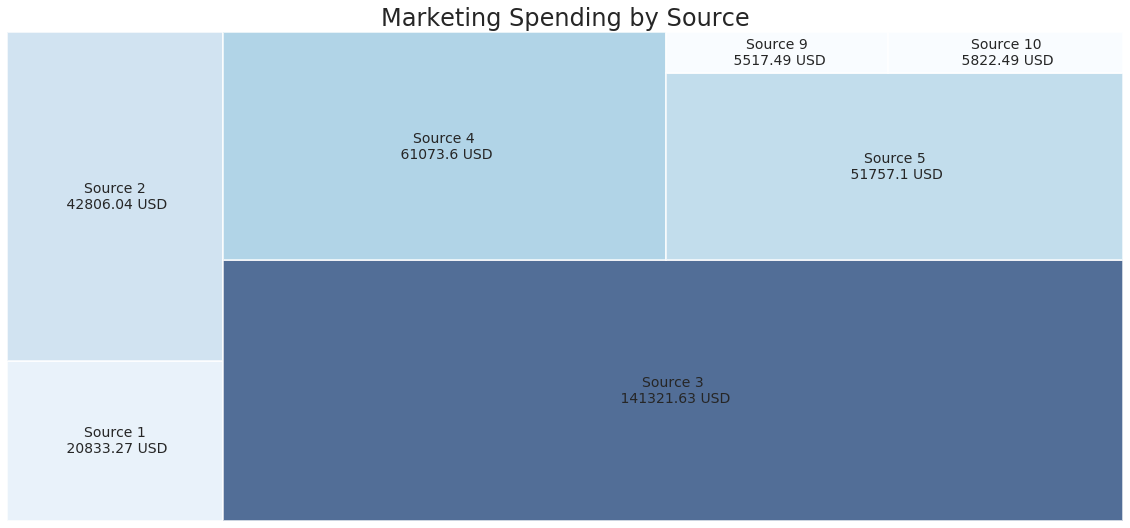

'Total Marketing Spending :'

329131.62

In [47]:
spend_by_source= costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
spend_by_source['source_id']= spend_by_source['source_id'].astype('int')
my_values= spend_by_source['costs']
cmap = matplotlib.cm.Blues
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
labels= ['Source {source}\n {costs} USD'.format(source= int(x[0]), costs= np.round(x[1],2)) for  x in spend_by_source.values]
plt.figure(figsize= (20,9))
plt.rc('font', size= 14)
squarify.plot(sizes= spend_by_source['costs'],linewidth= 2, label= labels,color= colors, alpha= 0.7)
plt.title('Marketing Spending by Source', size= 24)
plt.axis('off')
plt.show()

display("Total Marketing Spending :" ,spend_by_source.costs.sum().round(2))

The company has spent most resources on sources 3, 4 and 5. The lowest amounts were spent on Source 9 and 10.

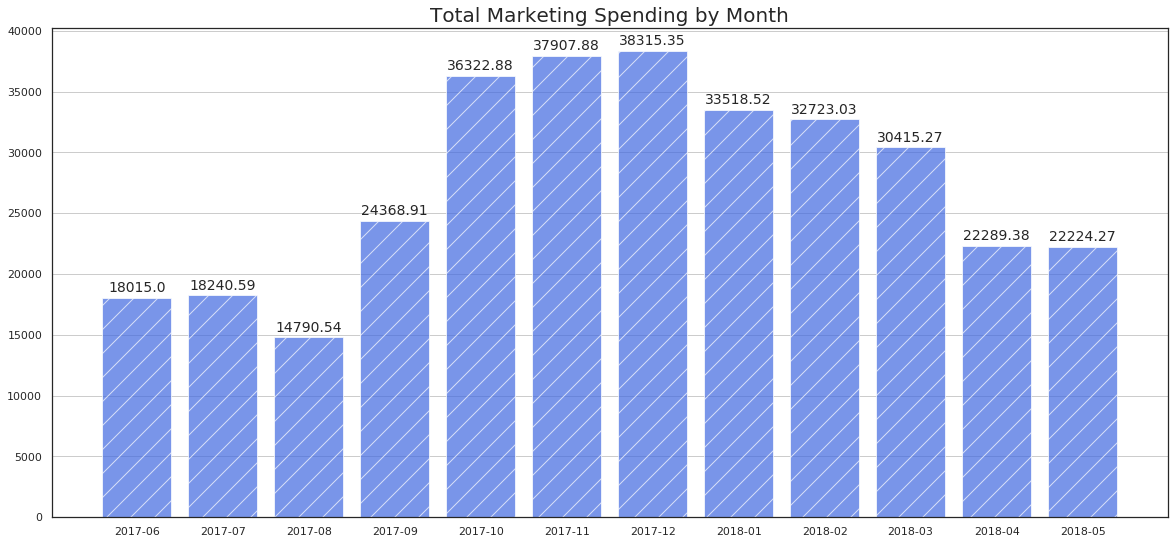

In [48]:
costs['dt']= pd.to_datetime(costs['dt'], format= '%Y-%m-%d')
costs['year_month']= costs['dt'].dt.to_period('M')
spend_by_month= costs.groupby('year_month').agg({'costs': 'sum'}).reset_index()
fig, ax= plt.subplots(figsize= (20,9))
x= np.arange(0, len(spend_by_month), 1)
sp= ax.bar(x, spend_by_month['costs'].round(2), color= 'royalblue', alpha= 0.7, hatch= "/")
ax.set_title('Total Marketing Spending by Month',size= 20)
ax.set_xticks(x)
ax.set_xticklabels(spend_by_month.year_month.values)
ax.yaxis.grid()
autolabel(sp)
plt.show()

The company has spent most resources in the months between October and December. The lowest amounts were spent in the first three months after launching the business. 

#### How much did customer acquisition from each of the sources cost?


In [49]:
log['source_of_first_visit']= log.loc[log.groupby('uid')['buy ts'].idxmin(), 'source_id']
user_source_cac= log.groupby('source_of_first_visit').agg({'uid':'nunique'}).reset_index()
spend_by_source['source_id']= spend_by_source['source_id'].astype('int')
user_source_cac['source_of_first_visit']= user_source_cac['source_of_first_visit'].astype('int')
source_cac= spend_by_source.merge(user_source_cac, left_on = 'source_id', right_on= 'source_of_first_visit')
source_cac['cac']= source_cac['costs']/source_cac['uid']

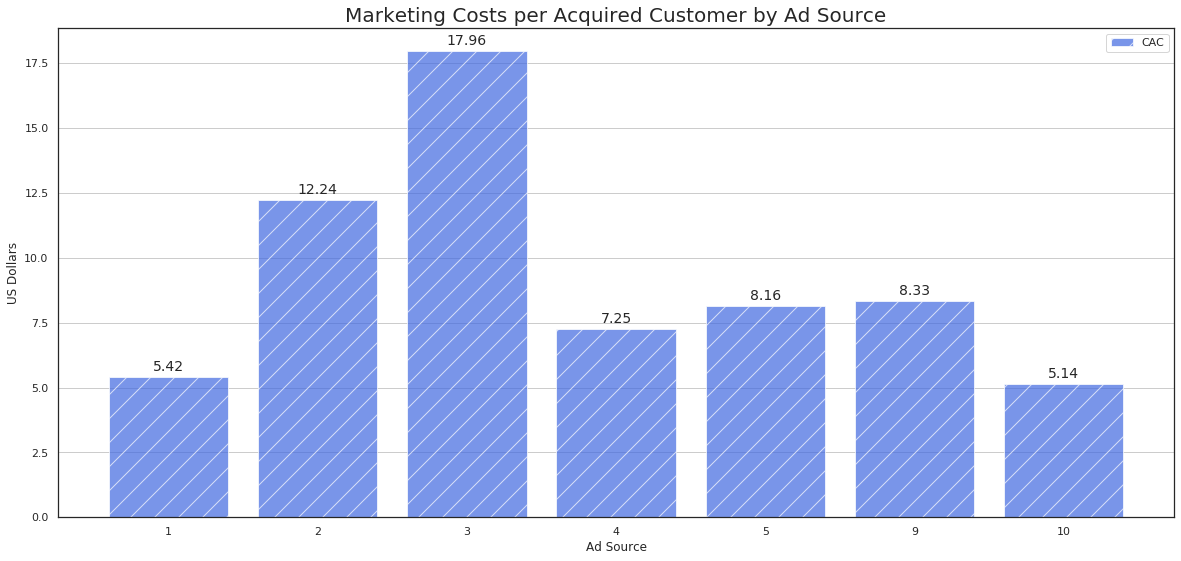

In [50]:
fig, ax= plt.subplots(figsize= (20,9))
x= np.arange(0,len(source_cac))
labels= list(source_cac.source_id)
cac= ax.bar(x, source_cac['cac'].round(2), label= 'CAC', color= 'royalblue', alpha= 0.7, hatch= "/")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Marketing Costs per Acquired Customer by Ad Source', size= 20)
ax.set_xlabel('Ad Source')
ax.set_ylabel('US Dollars')
ax.yaxis.grid()
ax.legend()
autolabel(cac)
plt.show()

Ad source 3 gives the least bang for the buck, requiring almost 18 USD for each newly acquired customer. The most effective ad source in terms of acquisition is number 10 with a CAC of 5.14 USD. 

#### How worthwhile were the investments? (ROI)

In [51]:
log['source_of_first_visit']= log.loc[log.groupby('uid')['buy ts'].idxmin(), 'source_id']
users_by_source= log.groupby('source_id').agg({'uid':'nunique','revenue':'sum'}).reset_index()
users_by_source['source_uid']=users_by_source['source_id'].astype('int')
cac_by_source= spend_by_source.merge(users_by_source, left_on = 'source_id', right_on= 'source_id')
cac_by_source['costs_per_cust']= cac_by_source['costs']/cac_by_source['uid']
cac_by_source['rev_per_cust']= cac_by_source['revenue']/cac_by_source['uid']
cac_by_source['ROMI']= cac_by_source['rev_per_cust']/cac_by_source['costs_per_cust']

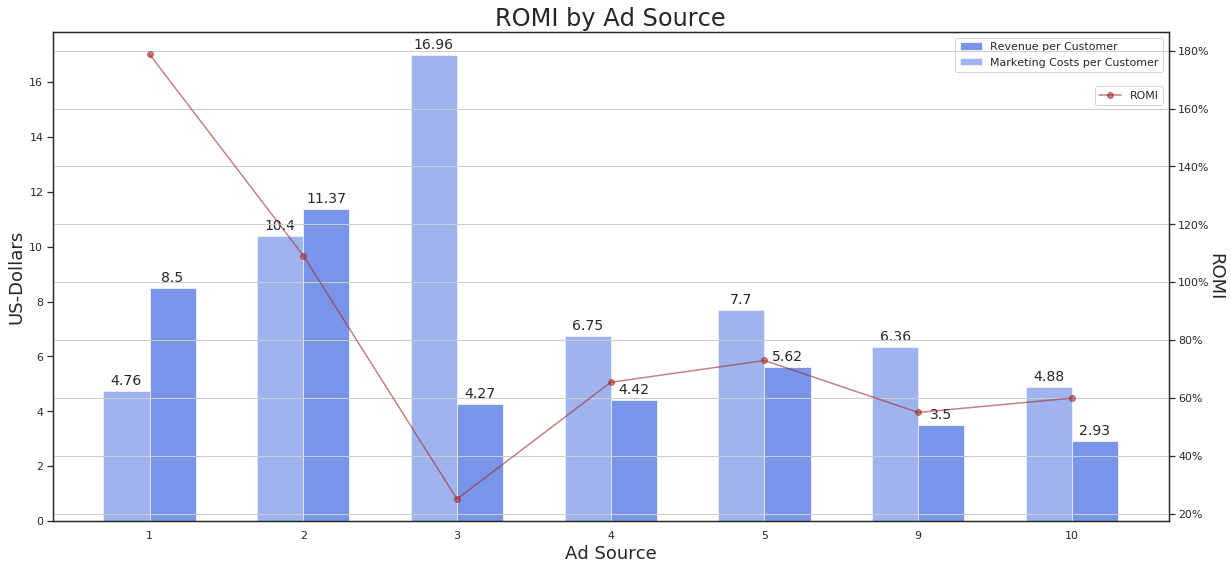

,source_id,costs_per_cust,rev_per_cust,ROMI
0,1,4.76,8.50,1.79
1,2,10.40,11.37,1.09
4,5,7.70,5.62,0.73
3,4,6.75,4.42,0.65
6,10,4.88,2.93,0.60
5,9,6.36,3.50,0.55
2,3,16.96,4.27,0.25


In [52]:
width= 0.3
fig, ax= plt.subplots(figsize= (20,9))
x= np.arange(0,len(cac_by_source))
labels= list(cac_by_source.source_id.values)
ltv= ax.bar(x+width/2,cac_by_source['rev_per_cust'].round(2), width= width, label= 'Revenue per Customer', color= 'royalblue', alpha= 0.7)
cac= ax.bar(x-width/2,cac_by_source['costs_per_cust'].round(2), width= width, label= 'Marketing Costs per Customer',color= 'royalblue', alpha= 0.5)
ax2= ax.twinx()
ratio= ax2.plot(x,cac_by_source['ROMI']*100, 'g-o',label= 'ROMI', color= 'brown', alpha= 0.6)
ax.set_ylabel('US-Dollars', size= 18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Ad Source',size= 18)
ax.legend(bbox_to_anchor=(1, 1))
plt.title('ROMI by Ad Source', size= 24)
ax2.set_ylabel('ROMI', size= 18, rotation= 270)
ax2.yaxis.set_label_coords(1.05, 0.5)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.legend(bbox_to_anchor=(1, 0.9))
ax2.grid()
autolabel(ltv)
autolabel(cac)
plt.show()
display(cac_by_source[['source_id','costs_per_cust', 'rev_per_cust','ROMI']].round(2).sort_values('ROMI', ascending= False))

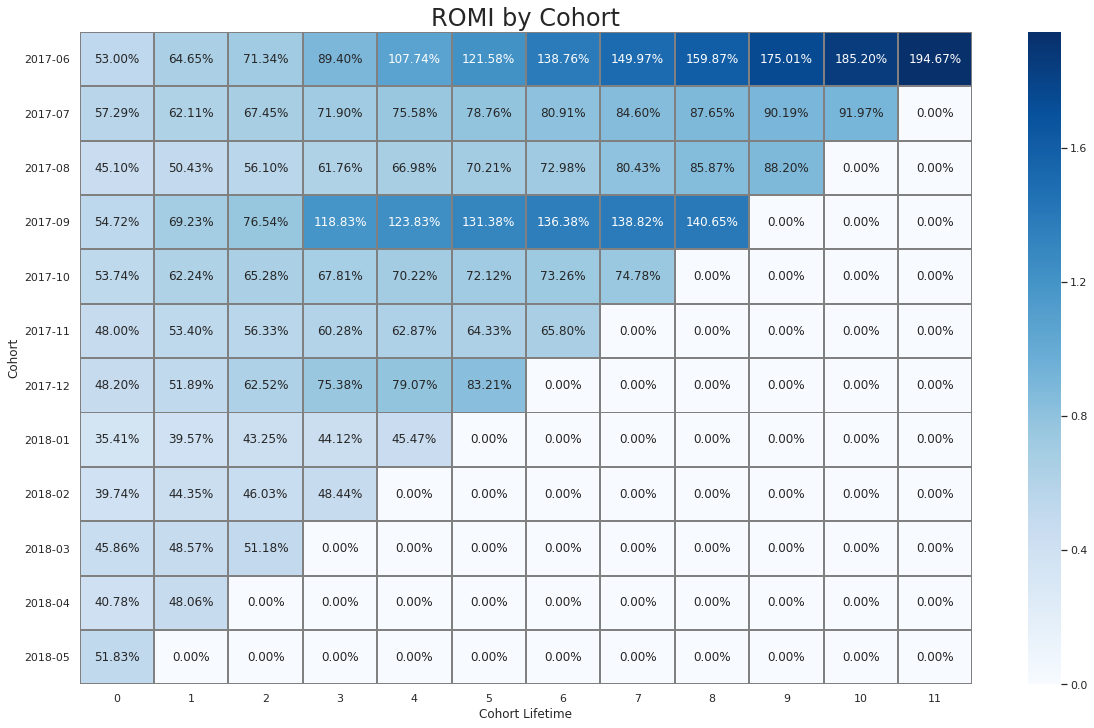

In [53]:
cohort_LTV= cohort_LTV[:12]
cohort_LTV['costs_per_month']= list(spend_by_month['costs'].astype('float'))
cohort_LTV['costs_per_customer']= cohort_LTV['costs_per_month']/cohort_LTV['Cohort Size']

for name ,data in cohort_LTV.drop(columns= ['Cohort Size', 'costs_per_month', 'costs_per_customer']).iteritems():
    cohort_LTV[name]= data/cohort_LTV['costs_per_customer']
    
    
#cohort_LTV

plt.figure(figsize= (20,12))

sns.set(style='white')
plt.title('ROMI by Cohort',size= 24)
sns.heatmap(cohort_LTV.drop(columns= ['Cohort Size', 'costs_per_month', 'costs_per_customer']), annot= True,fmt='.2%', linewidths=1, linecolor='gray', cmap= 'Blues')
plt.xlabel('Cohort Lifetime')
plt.ylabel('Cohort')
plt.yticks(rotation= 0)
plt.show()

<div class="alert alert-danger">
<s><b>Reviewer's comment v2:</b> Please, check this part. I've already written about LTV above, now let's pay atention to the CAC and ROMI. I think, the main problem is how you've selected source id of users. Compare your results with: <br>
<code>users_sources = visits.sort_values('start ts').groupby('uid')['source_id'].first().reset_index()</code>    

After that use your pre-computed LTV frome the previous stage and CAC per month to get ROMI. For example, (2017-07, 11) cohort should be 133%.   
</div>


The plots show that customers who came from ad source number 1 for their first visit bring the most money (ROMI 179%).
The other profitable ad source is number 2 with a ROMI of 109 %. 
The least profitable ad source is number 3 with a ROMI of 25%. 

In [54]:
#spend_by_month= spend_by_month.reset_index()
users_by_month= log.groupby('year_month_first_visit').agg({'uid':'nunique','revenue':'sum'}).reset_index()
cac_by_month= spend_by_month.merge(users_by_month, left_on= 'year_month', right_on= 'year_month_first_visit')
cac_by_month['rev_per_cust']= cac_by_month['revenue']/cac_by_month['uid']
cac_by_month['costs_per_cust']= cac_by_month['costs']/cac_by_month['uid']
cac_by_month['ROMI']= cac_by_month['rev_per_cust']/cac_by_month['costs_per_cust']

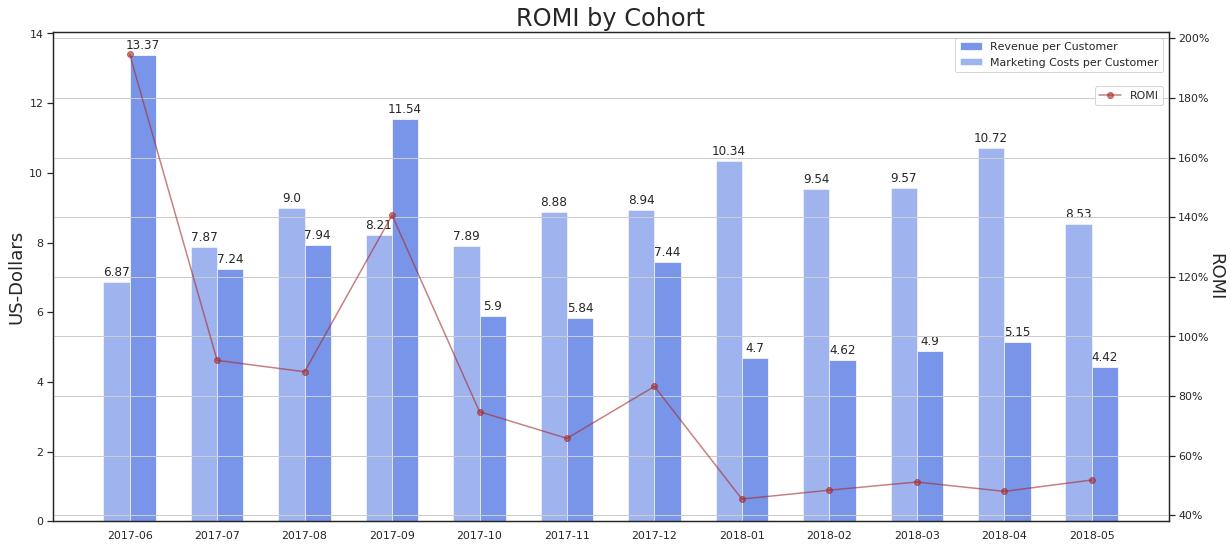

,year_month,costs_per_cust,rev_per_cust,ROMI
0,2017-06,6.87,13.37,1.95
3,2017-09,8.21,11.54,1.41
1,2017-07,7.87,7.24,0.92
2,2017-08,9.00,7.94,0.88
6,2017-12,8.94,7.44,0.83
4,2017-10,7.89,5.90,0.75
5,2017-11,8.88,5.84,0.66
11,2018-05,8.53,4.42,0.52
9,2018-03,9.57,4.90,0.51
8,2018-02,9.54,4.62,0.48


In [55]:
width= 0.3
fig, ax= plt.subplots(figsize= (20,9))
x= np.arange(0,len(cac_by_month))
labels= list(cac_by_month.year_month.values)
ltv= ax.bar(x+width/2,cac_by_month['rev_per_cust'].round(2), width= width, label= 'Revenue per Customer', color= 'royalblue', alpha= 0.7)
cac= ax.bar(x-width/2,cac_by_month['costs_per_cust'].round(2), width= width, label= 'Marketing Costs per Customer',color= 'royalblue', alpha= 0.5)
ax2= ax.twinx()
ratio= ax2.plot(x,cac_by_month['ROMI']*100, 'g-o',label= 'ROMI', color= 'brown', alpha= 0.6)
ax.set_ylabel('US-Dollars', size= 18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1, 1))
plt.title('ROMI by Cohort', size= 24)
ax2.set_ylabel('ROMI', size= 18, rotation= 270)
ax2.yaxis.set_label_coords(1.05, 0.5)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.legend(bbox_to_anchor=(1, 0.9))
ax2.grid()
autolabel(ltv)
autolabel(cac)
plt.show()
display(cac_by_month[['year_month','costs_per_cust', 'rev_per_cust','ROMI']].round(2).sort_values('ROMI', ascending= False))

The plots show that customers from cohort 2017-06 and 2017-09 are the only ones who are already profitable (ROMI of 195% and 141% respectively. The January Cohort is the least profitable one with a ROMI of a meagre 45 %.

<a id="conclusion"></a>
# 4 Conclusion and Recommendations


Looking at the health of Yandex.Afishas product and marketing activities, this report identified several areas where improvements should be made to make the company more profitable in the future. Below is a quick summary of the main issues: 

1. The application is losing active users (DAU, MAU, WAU are decreasing) 
2. The company is not able to retain many of its users 
3. Sales have been in steady decline since December 2017 
4. The majority of ad campaigns and user cohorts are not profitable for the company 

A very positive insight was the conversion rate of 16.01 %. However, not all campaign are equally successful. If the company is to improve in the future, spending should be geared towards more profitable ad campaigns. To that end, in my view conversion rates and ROMI are key metrics to be looked at to optimise the value of marketing expenses. Coming up with ways to increase retention is important as well but I believe that product-specific attributes will make this more difficult to accomplish.

Below I plotted ROMI against conversion to show which campaigns are successful. The size of the bubbles indicates how much money was spent on each campaign. The green shaded area represents positive returns while the red area stands for unprofitable investments. From the graph, it becomes clear that sources 1 and 2 are the cash cows of the company and thus spending for these sources should be heavily increased. Source 3 should be phased out entirely as it burns too much money and does not lead to much conversion. Source 9 does not help the business a lot either and should be discontinued as well. Sources 4,5 and 10 require additional scrutiny but could potentially help increase the range of the company and if certain modifications are made contribute to the profitability. 

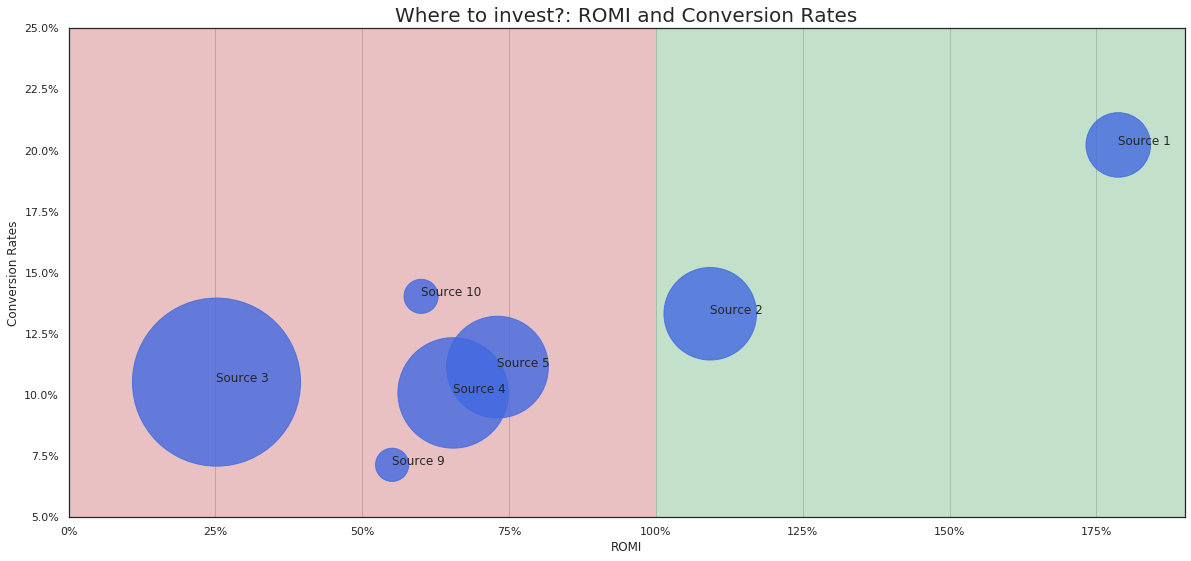

In [56]:
temp= cac_by_source.merge(tog2, how= 'left', on= 'source_id')[['source_id','ROMI', 'conversion_rate']]
invest= temp.merge(spend_by_source, how= 'left', on= 'source_id')
fig, ax= plt.subplots(figsize= (20,9))
plt.scatter(invest['ROMI']*100, invest['conversion_rate']*100,color= 'royalblue', alpha= 0.8, s= invest['costs']/5, zorder= 2)
ax.axvspan(100, 190, color='g', alpha=0.35, lw=0)
ax.axvspan(0, 100, color='r', alpha=0.35, lw=0)
ax.xaxis.grid()
ax.set_xlabel('ROMI')
ax.set_ylabel('Conversion Rates')
ax.set_title('Where to invest?: ROMI and Conversion Rates', size= 20)
ax.set_xlim(0, 190)
ax.set_ylim(5, 25)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())

for i, txt in enumerate(invest['source_id']):
    ax.annotate('Source {t}'.format(t= txt), (invest.ROMI[i]*100, invest.conversion_rate[i]*100))


plt.show()